![](https://cdn-images-1.medium.com/max/1200/1*surWujKv0sqceD1kOYpqtQ.png)

# First of all please read the theory, just to get a basic understanding
[Theory](https://www.analyticsvidhya.com/blog/2017/02/introduction-to-ensembling-along-with-implementation-in-r/)

Necessary libraries/tools

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warnings (as always)


from scipy import stats
from scipy.stats import norm, skew #to know where to apply Box-cox transformation

Read in the dataset

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Standard step: Remove id columns from both data sets since we are not going to need when modeling.

In [3]:
#Save it
train_id = train['Id']
test_id = test['Id']

#drop it
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)


**Data-Processing**

When performing regression it is always important to aim for normality, that is does our dependent variable follows normal distribution (theoretically it is important demand). Other than that we should also (in general) look for outliers to remove them from data. Either we have some sort of documentation about the data that specifically indicates that like [http://ww2.amstat.org/publications/jse/v19n3/Decock/DataDocumentation.txt] (http://) (under special notes) or we can do a joint plot of all of the variables versus the dependent variables. And get a hunch where the outlier might be hidden.

In [4]:
#g = sns.pairplot(data=train, palette = 'seismic',
                #size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) ) #problem is the size of the dataset. Execution is to long, that is why we are going to focus only on notes and look at the problematical variable

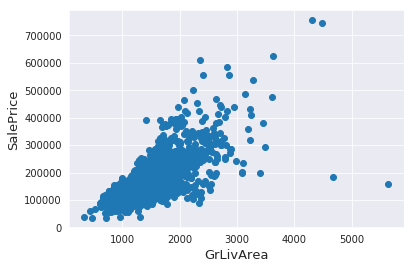

In [5]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

Remove

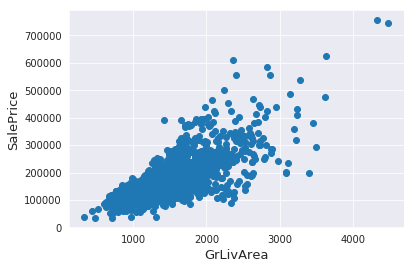

In [6]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

**NOTE** We should be careful with outliers, always removing them is not the best choice. It could happen that we have also outliers in the test set. Than removel from training set will not give desired predictions. We should rather opt for another choice and that is scaling/transformations in order to make our model robust to the outliers

*Normality Assumption* AS already mentioned we ought to make normality assumptions when dealing with regression. First we need to check whether it is neccesary.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = 180932.92 and sigma = 79467.79



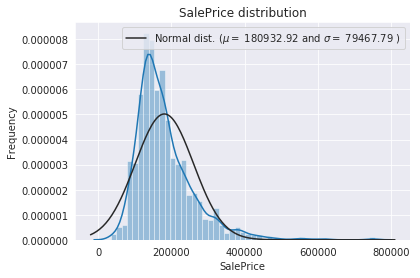

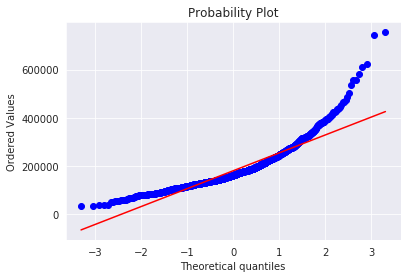

In [7]:
sns.distplot(train['SalePrice'] , fit=norm); #Informal plot, where blue line is  our data and the black is the theoretical normal distribution

# Fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Legend
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Formally with QQ-plot we can determine wether distribution is normal
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

Log transformation is just a special case of Box-Cox transformation, let us apply it on our prices data to make it more normal.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = 12.02 and sigma = 0.40



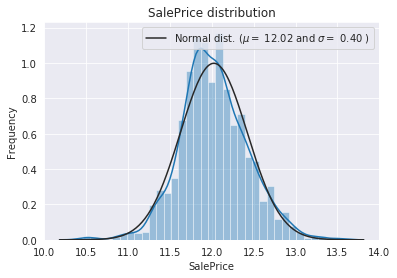

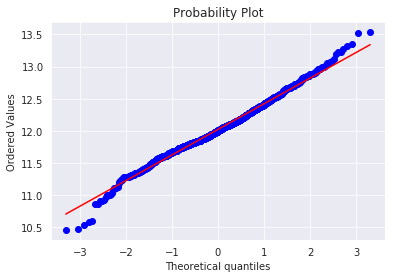

In [8]:
#log1p applies log(1+x) (because of 0 values) transformation
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

**Feature engineering**

In [9]:

all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True) #data to be predicted
print("all_data size is : {}".format(all_data.shape))
y_train = train.SalePrice.values

all_data size is : (2917, 79)


Standard approach, missing data, scaling, imputating etc...

In [10]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageQual,5.450806
GarageCond,5.450806
GarageFinish,5.450806
GarageYrBlt,5.450806


Plot the distribution of missing values

Text(0.5,1,'Percent missing data by feature')

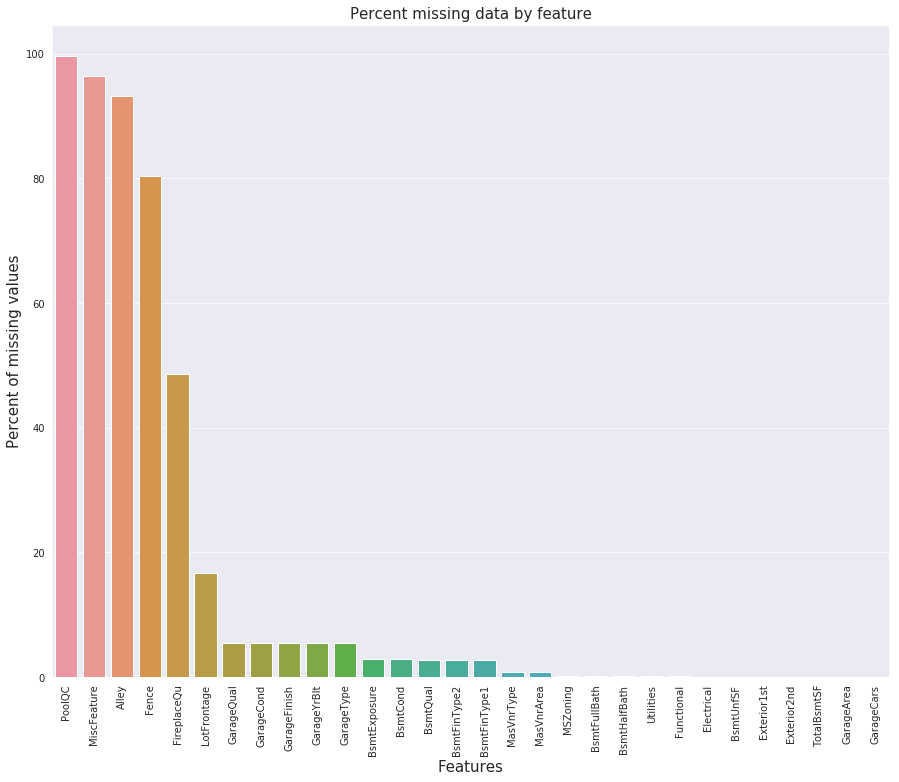

In [11]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

Lets go variable by variable and inpute the values (if possible/reasonable)! Question that we need to ask ourselves what does NaN stand for this specific feature and then imupte it accordingly.

PoolQC: NA means "No Pool"

In [12]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("No pool")

MiscFeature :  NA means "no misc feature"

In [13]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

Now there are a couple of them where missing values indicites None (meaning it does not exist) so we can jsut write a for loop for these columns:


In [14]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',"FireplaceQu","Fence","Alley"):
    all_data[col] = all_data[col].fillna('None')

*LotFrontage*: Linear feet of street connected to property. Now this property of the house is most likely going to be similiar to the other ones in the neighbourhood. ´SO let us group and impute with the median (due to potential outliers)

In [15]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

Another thing that we can notice is that some variables will inherit the imputed value due to the fact that we do not have the object at hand. For example havign no garage implies for the following 3 variables that NaN means 0

In [16]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

Same for basement

In [17]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

Likewise for categorical values of basement NaN will imply "None"

In [18]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

We go further down the list with our missing features. This is the most boring part when we have this many variables but the procedure is the same. What does NaN most likely mean for this variable, and does it even make sence to impute it?

 NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.


In [19]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

MSZoning: since "RL" is the most common values, we are going to use mode to impute it

In [20]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

Utilities : This categorical variable has almost all of the observations as "AllPub", except for one "NoSeWa" and 2 NA . No predictive power!---remove

In [21]:
all_data = all_data.drop(['Utilities'], axis=1)

Functional: Read the data descritpion or documentation, there we can see that NA means typical

In [22]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")


We are moving futher down our list
Electrical has one NA value. Since this feature has mostly 'SBrkr' (but not only), we can set that for the missing value.

In [23]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

KitchenQual: Same as for electrical, we can see only one missing values and we are going to impute it with the most occuring one

In [24]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

Exterior1st and Exterior2nd and SaleType have just one missing values (both of them are strings!) so we are just going to impute with the most common string!

In [25]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [26]:
# The test example with ID 666 has GarageArea, GarageCars, and GarageType 
# but none of the other fields, so use the mode and median to fill them in.
test.loc[666, "GarageQual"] = "TA"
test.loc[666, "GarageCond"] = "TA"
test.loc[666, "GarageFinish"] = "Unf"
test.loc[666, "GarageYrBlt"] = "1980"

# The test example 1116 only has GarageType but no other information. We'll 
# assume it does not have a garage.
test.loc[1116, "GarageType"] = np.nan

# For imputing missing values: fill in missing LotFrontage values by the median
# LotFrontage of the neighborhood.
lot_frontage_by_neighborhood = train["LotFrontage"].groupby(train["Neighborhood"])

That should be it with NaN, let us check

In [27]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio


**Data Correlation**

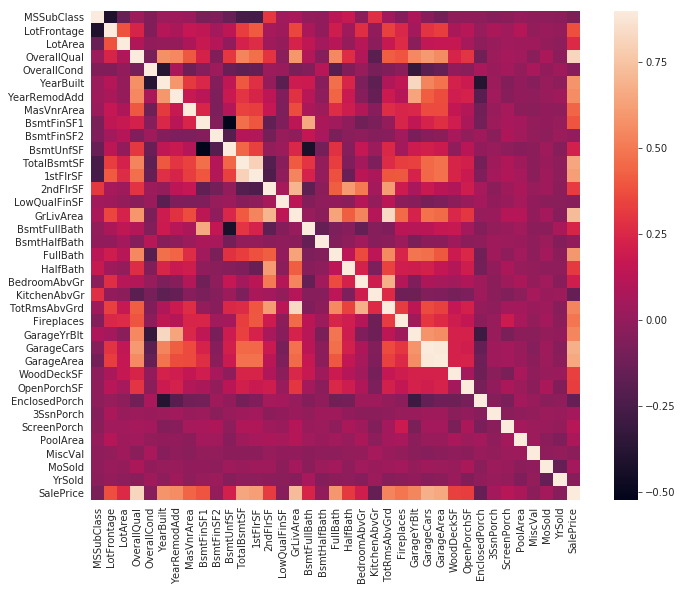

In [28]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

**How to think about this correlation heat-map**

The correlation coefficient is bound between -1 and 1 and tells you the linear relationship between these two variables. A coefficient close to 1 means a strong and positive associantion between the two variables (when one of them grows, the other does, also, and when one of them decreases, the other one does the same).
A coefficient close to -1 means strong negative association between the two variables, this is, observations with a large value in one of the variables tend to have a small value in the other variable or vice-versa.
A coeffcient close to 0 means no linear relation between the two variables.
Yo have to be careful with the following matters:
1) Association does not mean necessarily a causal relation between both variables. For example, there might be a third variable you have not cosidered and this third variable might be the explanation for the behaviour of the other two.
2) Even if there is a causal relationship between the variables, the correlation coefficient does not tell you which variable is the cause and which is the effect.
3) If the coefficient is clse to 0, it does not necessarily mean that there is no relation between the two variables. It means there is'nt a LINEAR relationship, but there might be another type of functional relationship (for example, quadratic or exponential).

So what is our next step in data processing? We should note that ML algorithms can only process numerical data (it needs to be encoded in numerical format), hence we ought to labelEncode (if there is hierarchy in the independent variable, i.e. good, better best---0 ,1 ,2) or Dummy encode (0 and 1 vectors). Next we should also think about what variables are actually categorical even tough they numerical or strings. For fully numerical values we should also think about skewnes (how can we remedy it?). Is there any text that we can extract info from? And finally what about scaling, we need to make our data comparable and robust to outliers!

For example, our first column MSSUbClass should be actually categorical, and not only that but with some hiararchy also (since there is difference whether it is 120 or 20)

**NOTE** if we do not labelENCODE numerical variables BEFORE we apply dummy encoding, than these variables will never be encoded. Since dummy encoding works only on categorical variables.

In [29]:
# First we need to make sure they are strings in order to make sure labelEncoding can be applied
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [30]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


New feature, total sqaure footage:

In [31]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

AS soon as we have numerical variables, check for skeewnes and correct it

In [32]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


Coreect it with Box-Cox method

In [33]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 59 skewed numerical features to Box Cox transform


**Dummy Encoding**

In [34]:
all_data = pd.get_dummies(all_data)

ntrain = train.shape[0]
ntest = test.shape[0]
train = all_data[:ntrain]#newdata
test = all_data[ntrain:]

**MODELING**

First couple of "simple" models than we are going to stack them (using Python classes) into more powerful and accurate model.

In [35]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline #using a pipeline we can chain together modeling and scaling where it is neccesary
from sklearn.preprocessing import RobustScaler #scaling in pipeline (robust to outliers!)
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [36]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values) #shuffle=True, shuffles the whole data set before each cross-validation split
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

**Models**
But before we proceede we should note that we did not scale anythin until now. Scaling should take place before PCA or kNN for example because different metrics will affect the results. Also when performing gradient descent not scaling might slow-down the speed of algorithm. In Lasso and Ridge regression penalise the outliers, hence we need to make sure outliers are on the same scale (across all of the features).

**Lasso**

In [37]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

**Elastic Net Regression :**

In [38]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

**Kernel Ridge Regression :**

In [39]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

**Gradient Boosting Regression :**

In [40]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

**XGBoost :**

In [41]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)


**LightGBM :**

In [42]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

**Base models scores**

In [43]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


Lasso score: 0.1115 (0.0074)

ElasticNet score: 0.1116 (0.0074)

Kernel Ridge score: 0.1153 (0.0075)

Gradient Boosting score: 0.1177 (0.0080)

Xgboost score: 0.1162 (0.0078)

LGBM score: 0.1162 (0.0071)



# Ensamble learning methods: 
All of the methods here presented aim in the end to optimise following function:

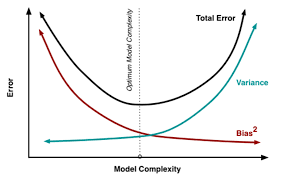



**Simplest ensambling approach : Averaging base models**
We begin with this simple approach of averaging base models. We build a new class to extend scikit-learn with our model and also to laverage encapsulation and code reuse (inheritance). A way to look at classes is that they are now same type as our model. Meaning we define which functionalities they will have. Very simply said, **avaraging base method** uses predictions (y_prediction) avarage values of all the algorithms as our final prediction. In more complicated ensembling (further below) WE add a meta-model which is trained on the predictions from the previous ones. (Please differentiate betweent boosting (ensamle method) where we "stack"-build up on residuals of the former-weaker models!

In [44]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

Let us average all of them :)

In [45]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso,model_xgb,model_lgb))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1088 (0.0073)



We first define a rmsle evaluation function

In [46]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# Stacking
It is an ensambling method were we use predictions of other models to make the final prediction. Please do consult the link in the begininng to understand the concept. In short what happens is that we have moved one step toward the true solution (here with averaging of bagging method) and now for the final model (here it is xgboost) we will be using actually predictions as predictor variables. So now if we have had on the initial M models n predictors that are used to make predictions. Than on the second model we will have M predictors (for M models) and the same number of rows in other words observations. But here is the crucial part, what observations? **k-fold cross validation** has to be used when training the first set of models. In order to make sure that we really exploit weaknesses and strengths of different models we need to know were are they stron or weak, if we were not to use k-fold cross validation than we would not find out. Predictions from a validation (hold-out) set are going to be the new features of the final model

In [47]:
averaged_models.fit(train.values, y_train)
stacked_train_pred = averaged_models.predict(train.values)
stacked_pred = np.expm1(averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))


model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))


model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))


'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

0.07621010616038269
0.0785165142425036
0.07307464036005418
RMSLE score on train data:
0.07478859074775006


Submit

In [48]:

sub = pd.DataFrame()
sub['Id'] = test_id
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)